In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

from utils import *

# Set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# 1. Load data

In [2]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# 2. Model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d_hidden = 20

class VAE(nn.Module):
    def __init__(self, d=d_hidden):
        super().__init__()
        self.d = d

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar
    

model = VAE().to(device)

def loss_function(x_hat, x, mu, logvar): 
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1+ logvar - mu.pow(2)- torch.exp(logvar)) 

    return BCE + KLD


# 3. Training

====> Test set loss: 98.8380
====> Epoch: 1 Average loss: 108.1293
====> Test set loss: 97.7288
====> Epoch: 2 Average loss: 107.5264
====> Test set loss: 98.0999
====> Epoch: 3 Average loss: 107.0517
====> Test set loss: 97.6536
====> Epoch: 4 Average loss: 106.5939
====> Test set loss: 97.1206
====> Epoch: 5 Average loss: 106.3118
====> Test set loss: 97.1218
====> Epoch: 6 Average loss: 105.9651
====> Test set loss: 97.1704
====> Epoch: 7 Average loss: 105.6775
====> Test set loss: 96.4581
====> Epoch: 8 Average loss: 105.4684
====> Test set loss: 95.9399
====> Epoch: 9 Average loss: 105.2363
====> Test set loss: 96.2368


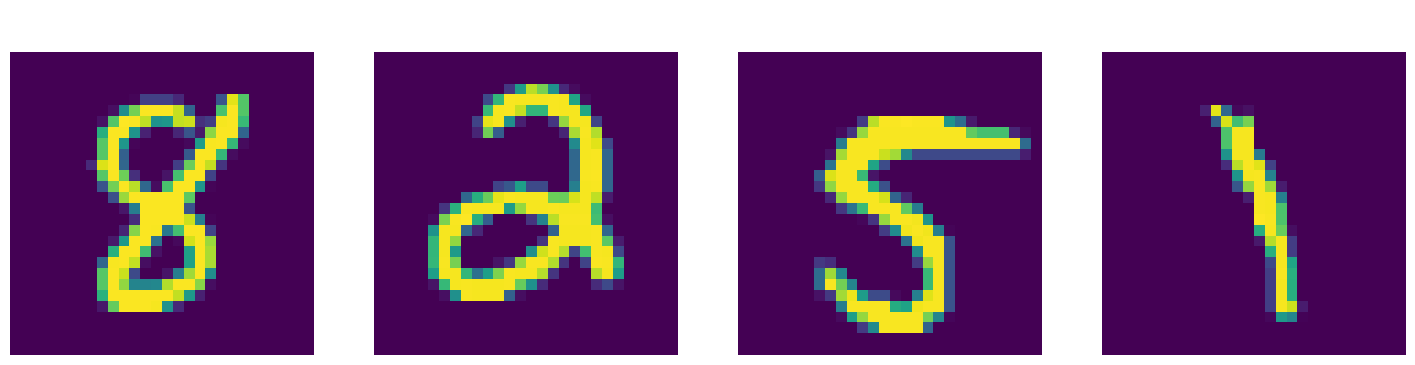

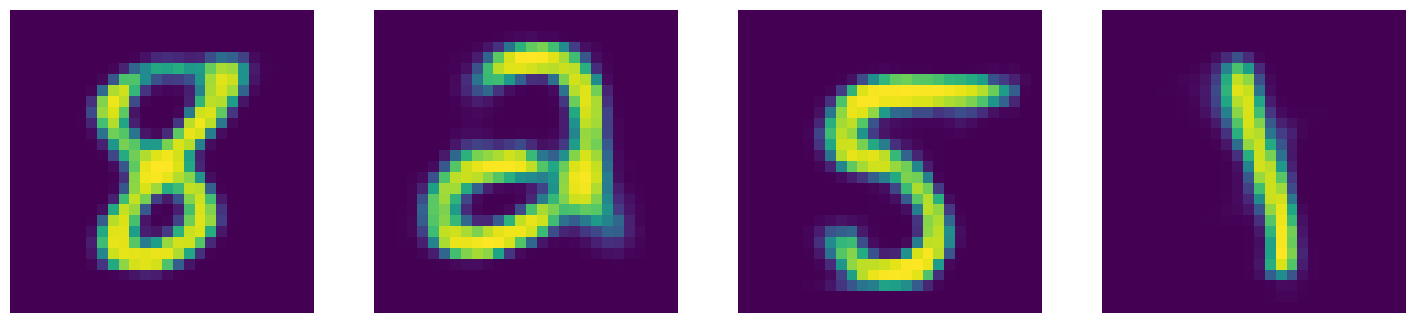

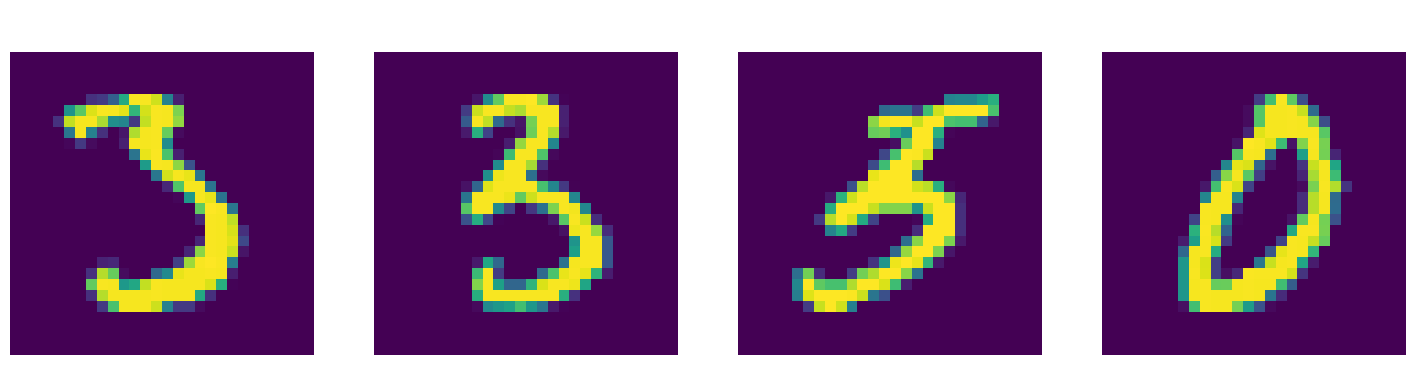

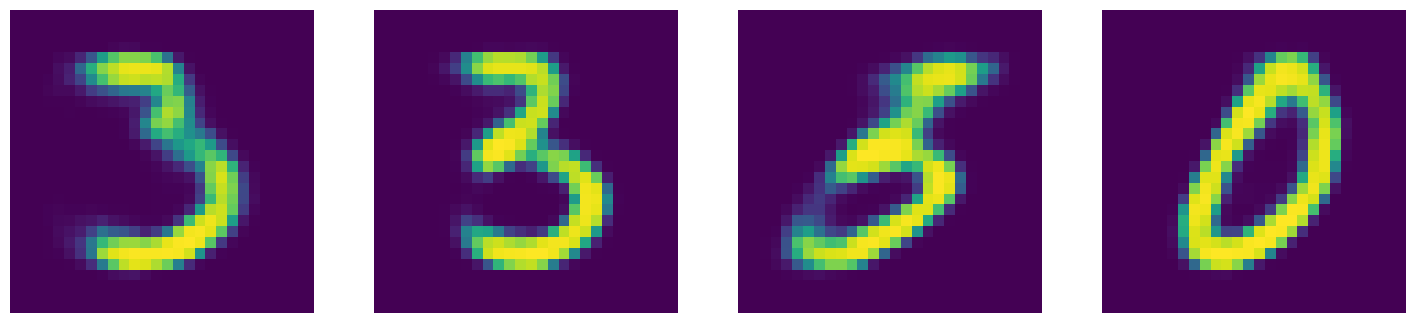

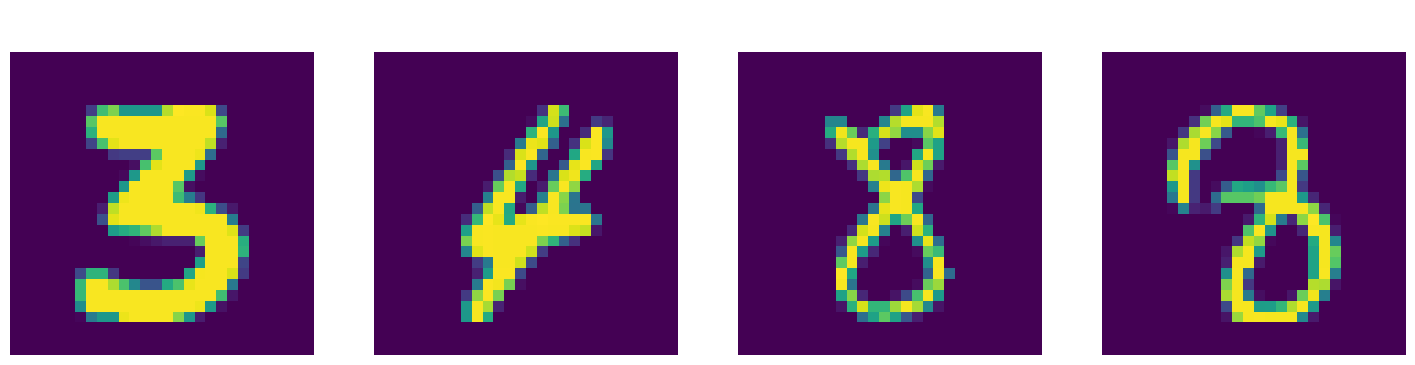

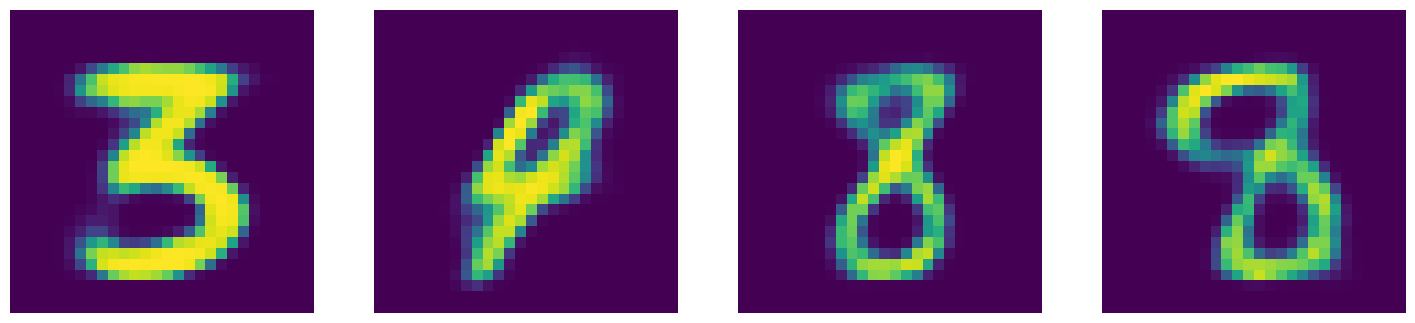

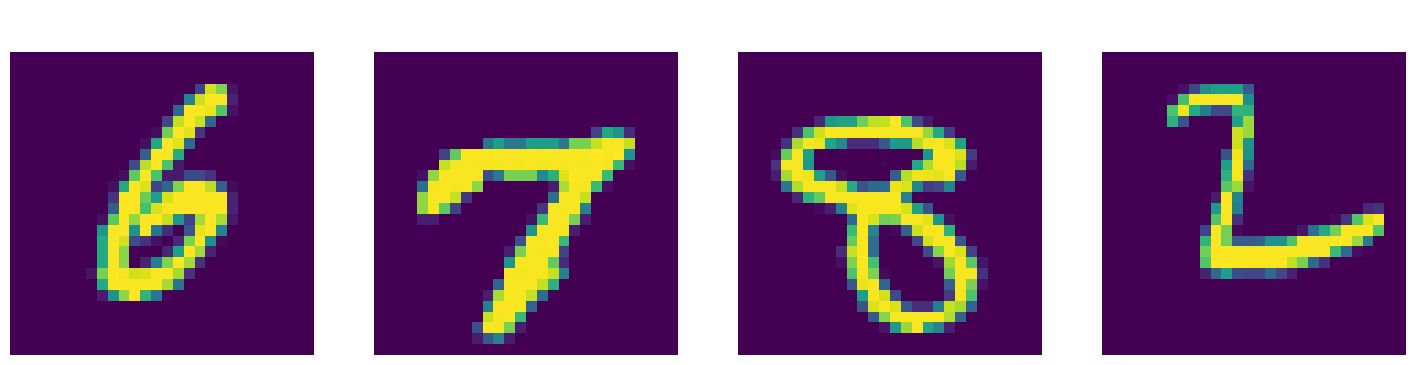

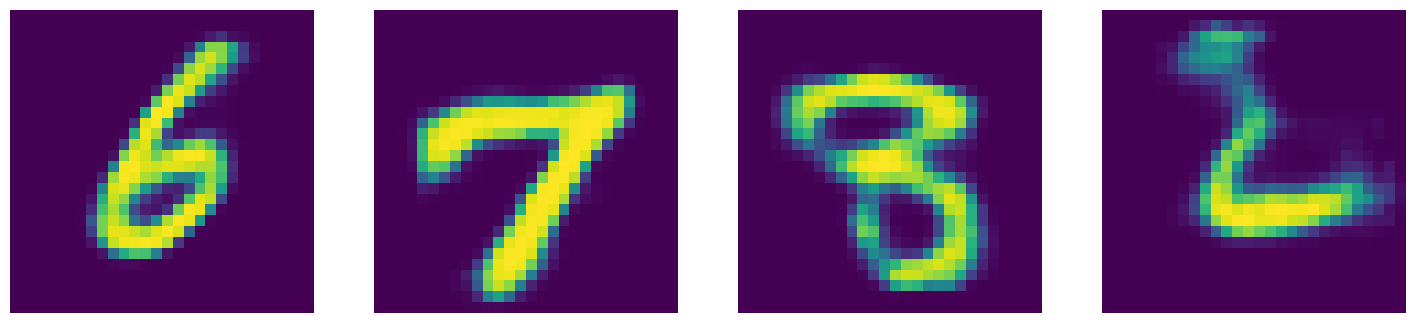

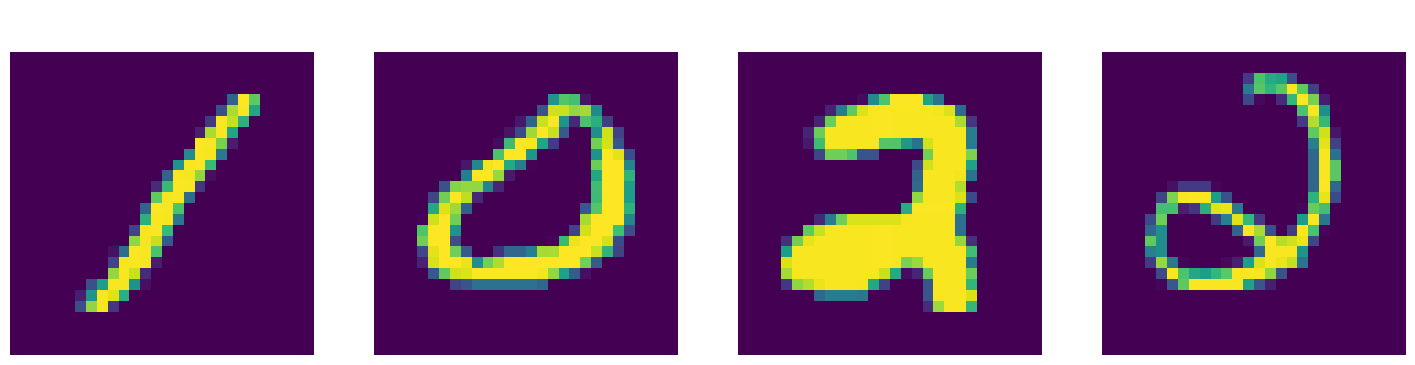

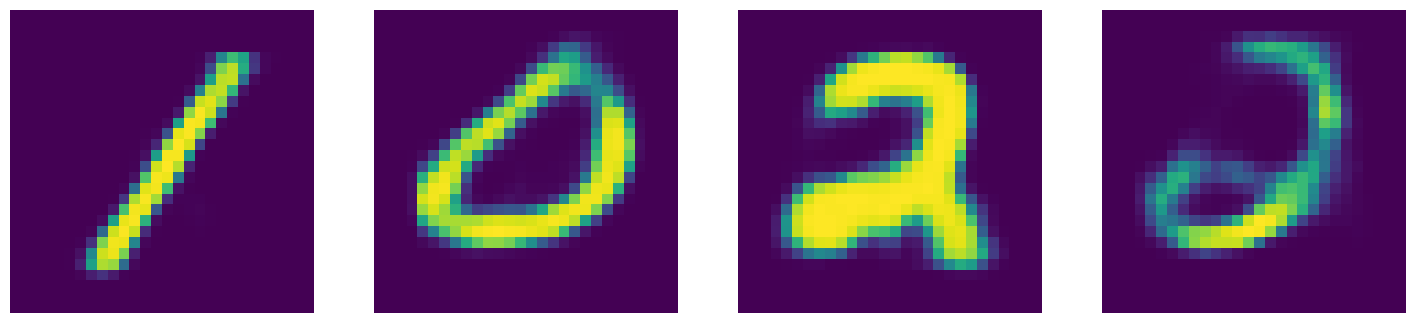

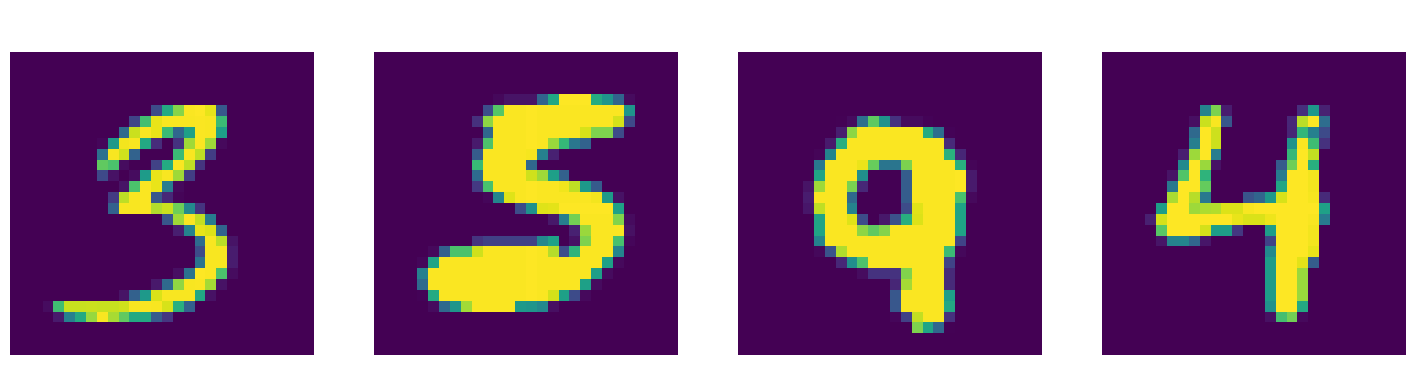

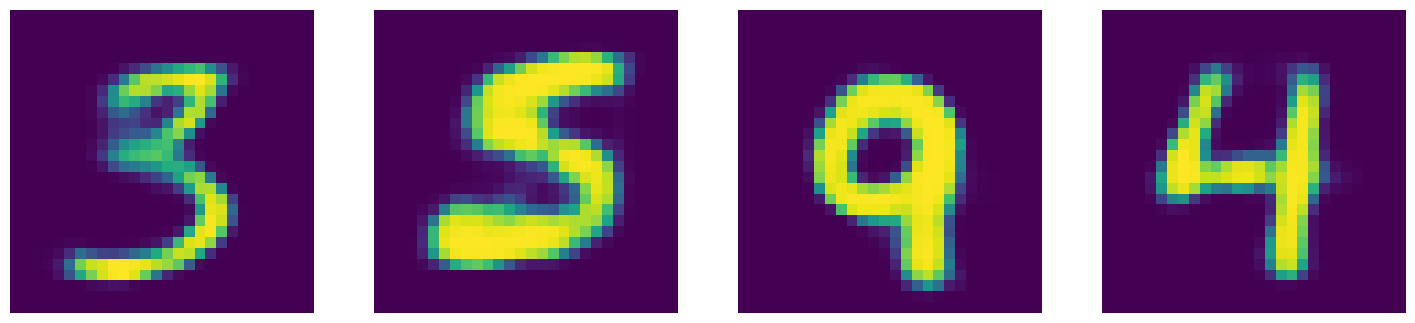

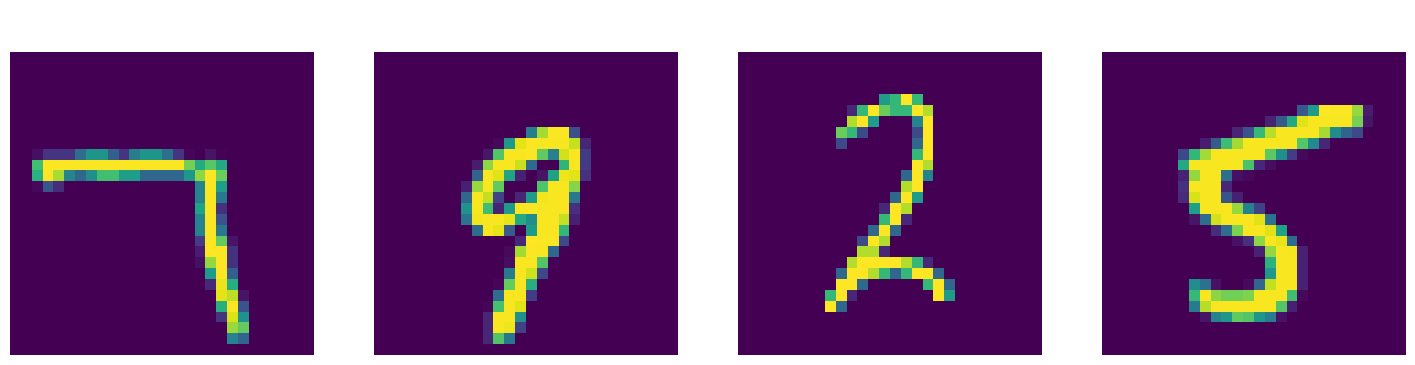

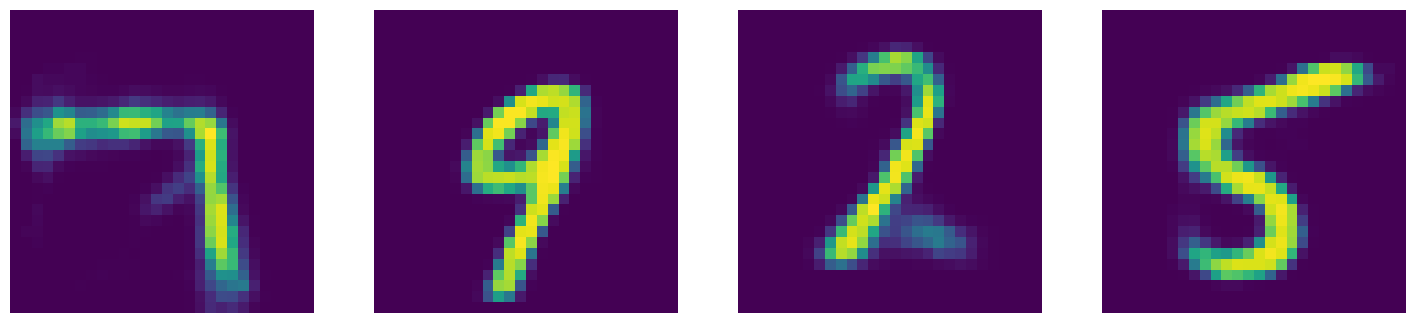

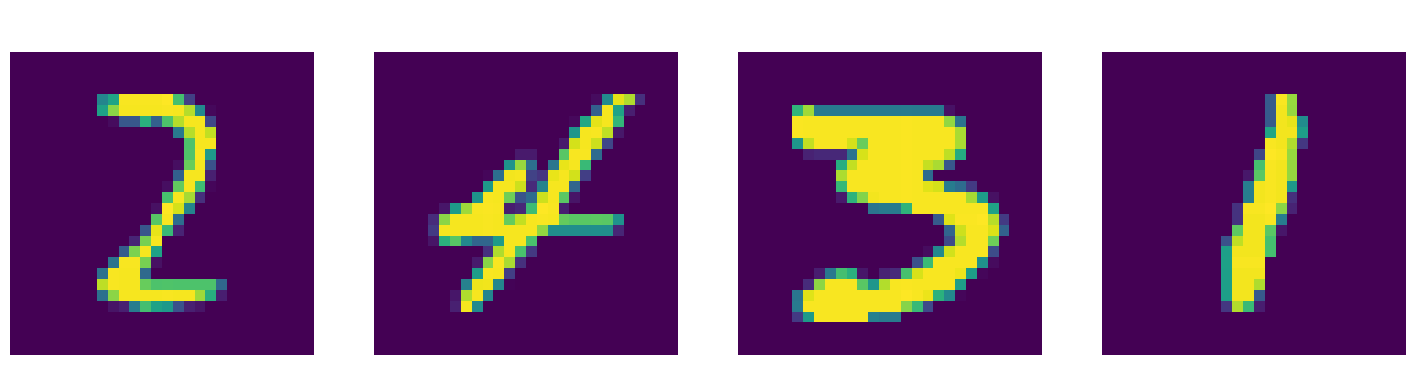

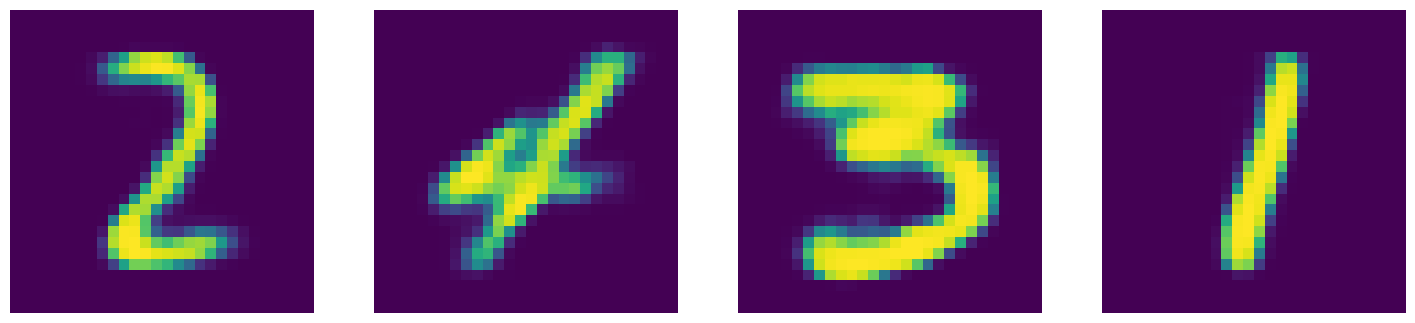

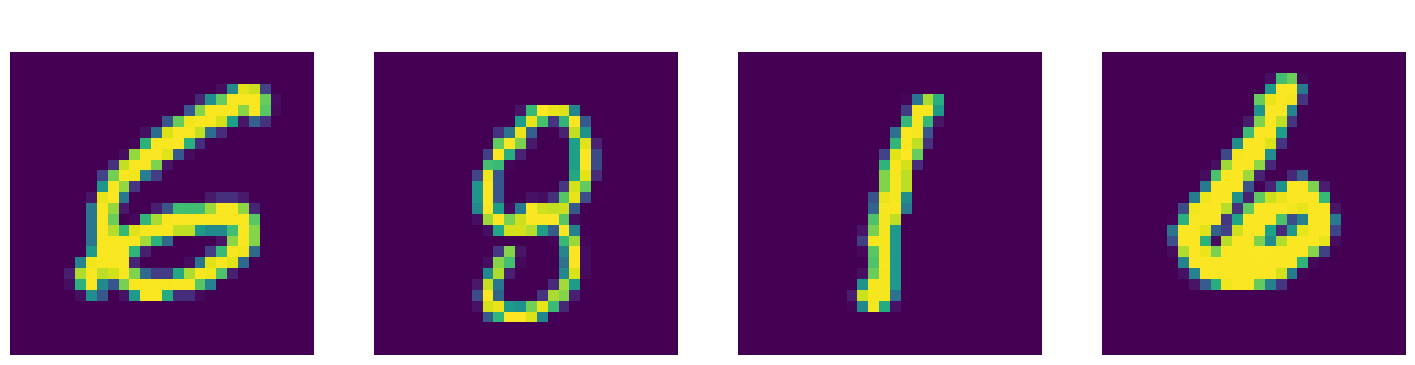

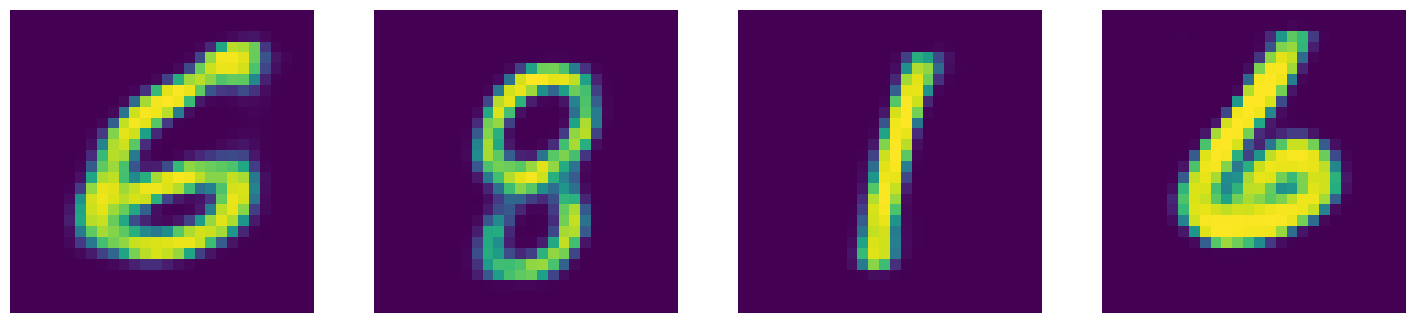

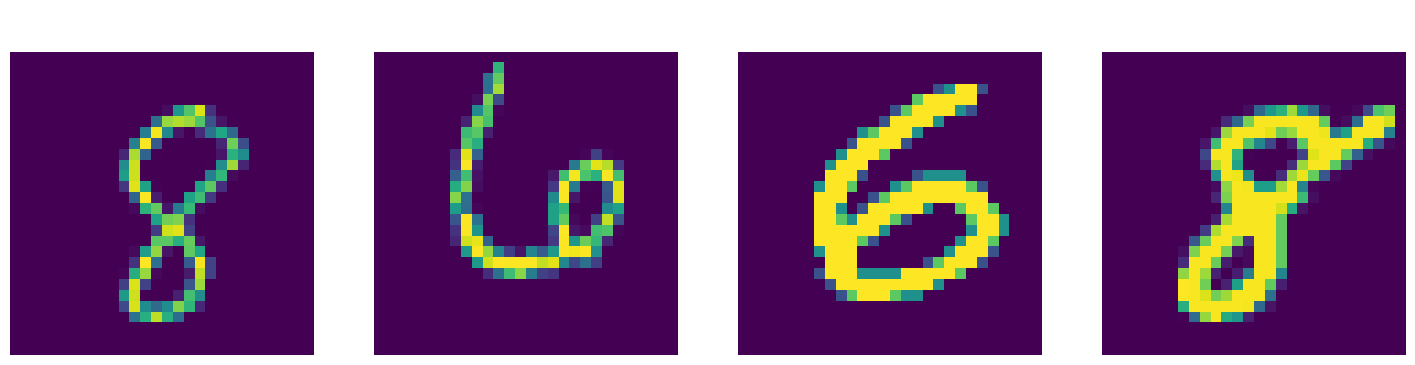

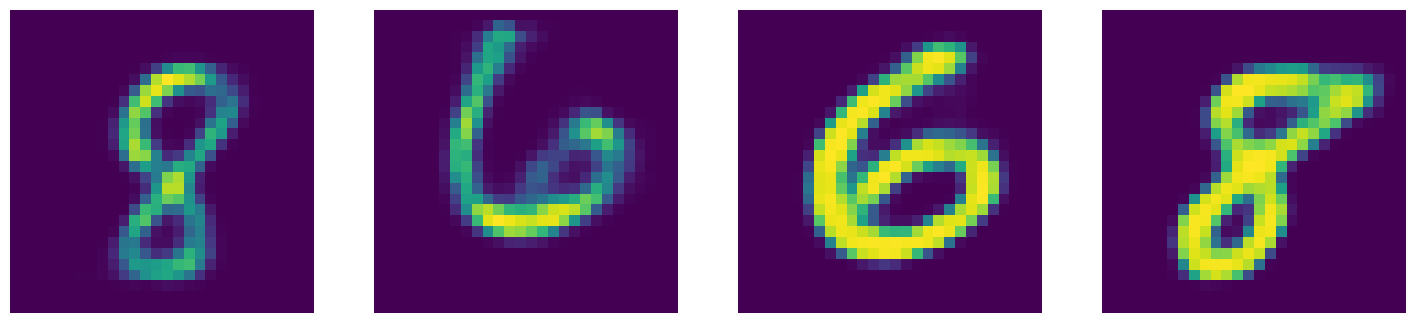

In [14]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

# Training and testing the VAE

num_epochs = 10
values = {'mu': list(), 'logvar': list(), 'label': list()}
for epoch in range(num_epochs):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    values['mu'].append(torch.cat(means))
    values['logvar'].append(torch.cat(logvars))
    values['label'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images_VAE(x, x_hat, 1, f'Epoch {epoch}')

torch.save(model, './results/vae.pth')

# 4. Generating a few samples

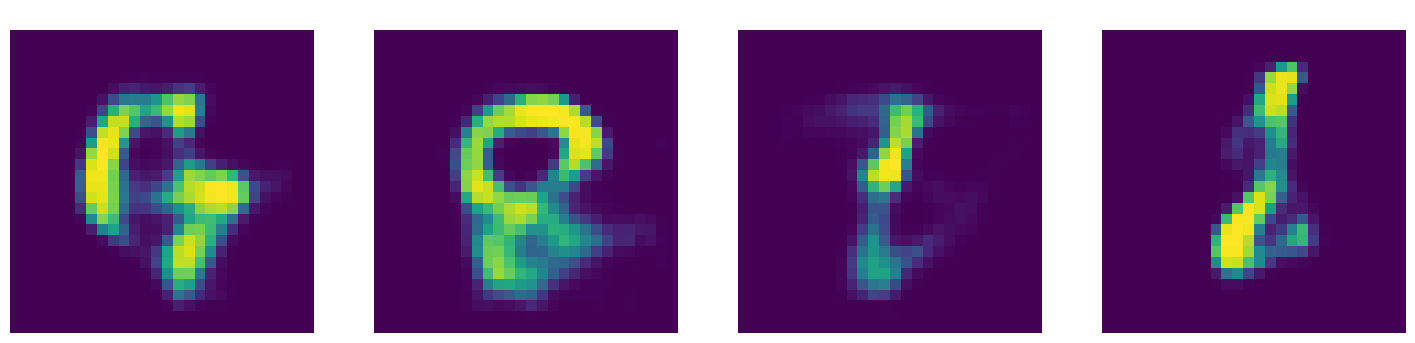

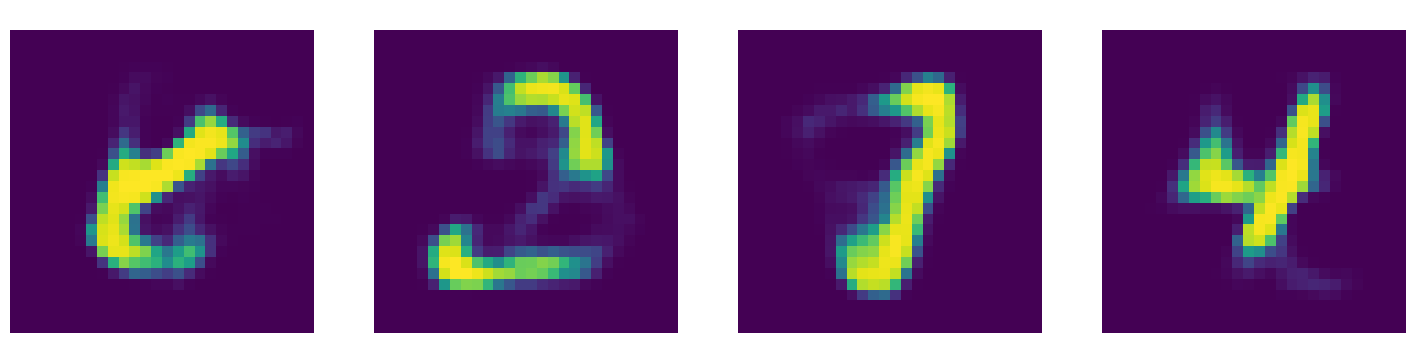

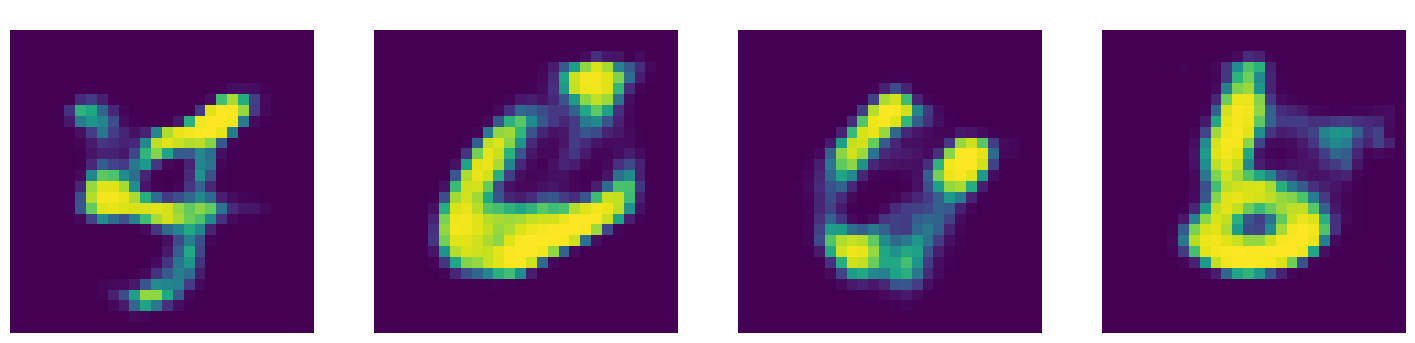

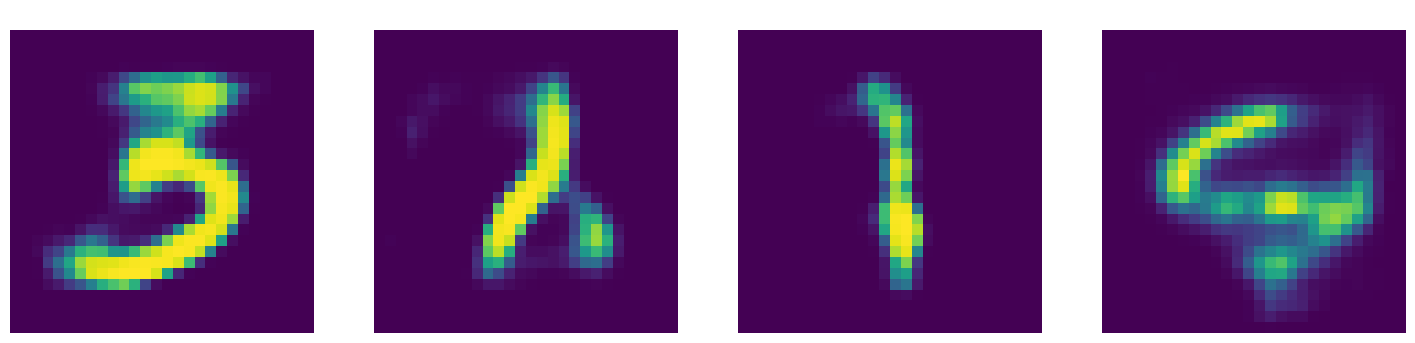

In [15]:
model = torch.load('./results/vae.pth')
N = 16
z = torch.randn((N, d_hidden)).to(device)
samples = model.decoder(z)
display_images_VAE(None, samples, N // 4, count=True)

# 5. Interpolation

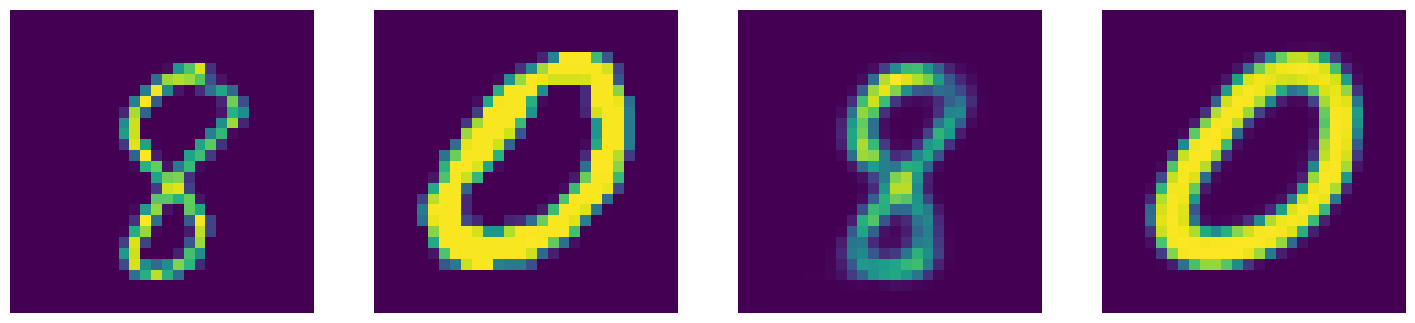

In [23]:
start, end = 0,14
sample_z = torch.stack((mu[start], mu[end]), 0)
sample = model.decoder(sample_z)
display_images_VAE(None, torch.stack(((
    x[start].view(-1),
    x[end].view(-1),
    sample[0],
    sample[1]
)), 0))

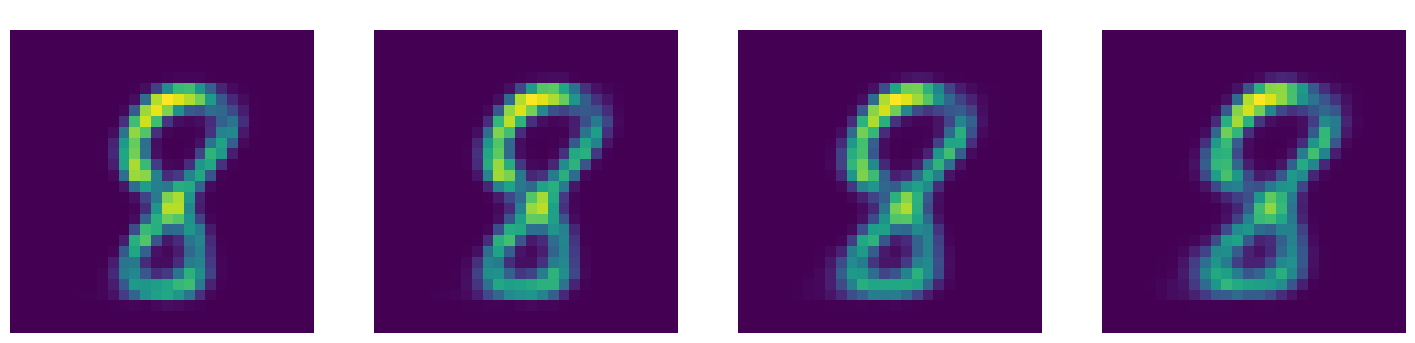

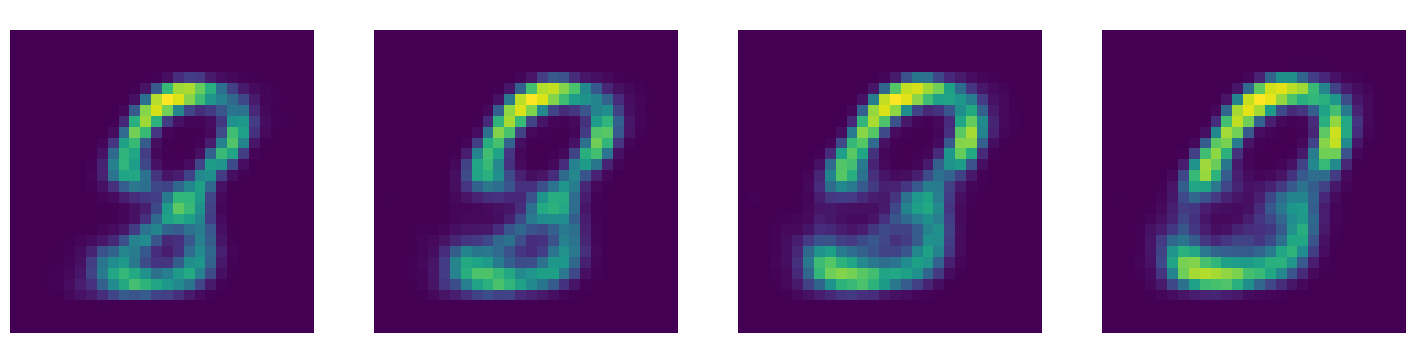

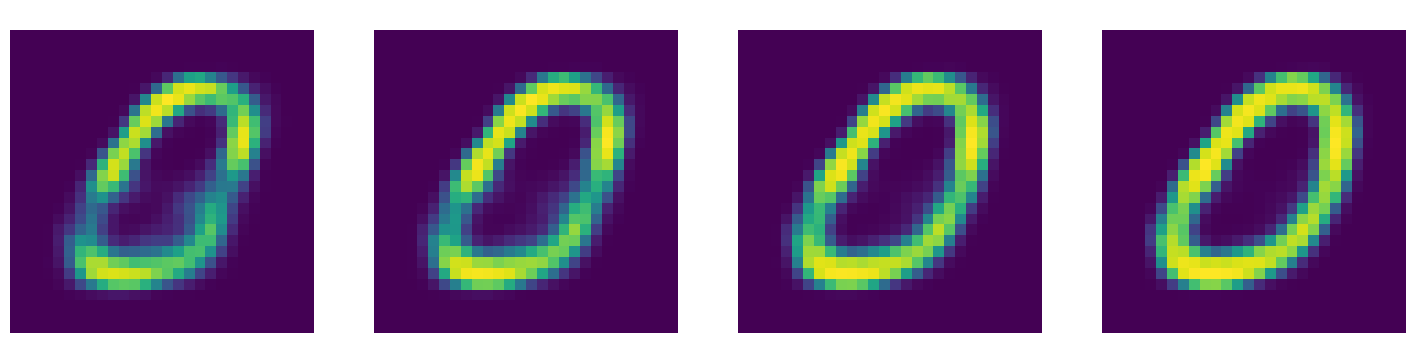

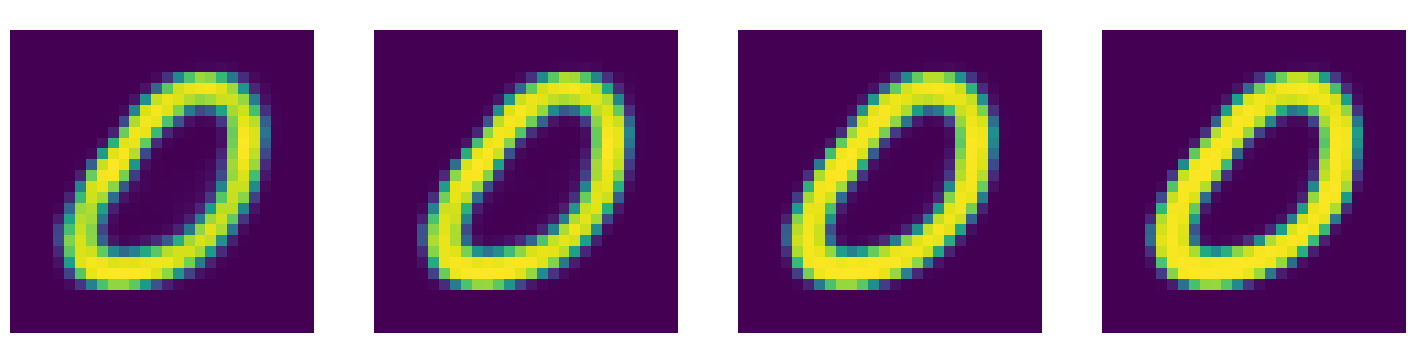

In [27]:
num_points = 16
interpolation = torch.Tensor(num_points, 20).to(device)
for i in range(num_points):
    interpolation[i] = i / (num_points - 1) * mu[end] + (1 - i / (num_points - 1) ) * mu[start]
sample = model.decoder(interpolation)
display_images_VAE(None, sample, num_points // 4, count=True)

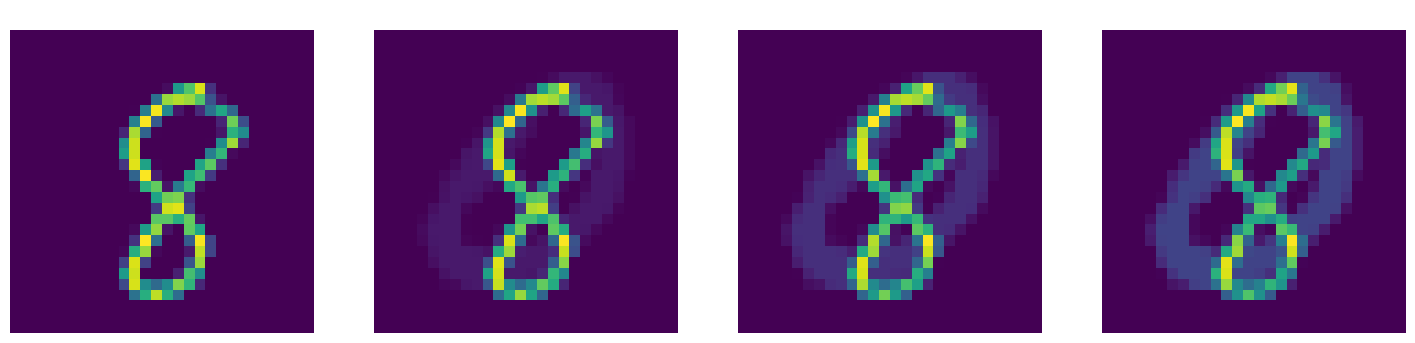

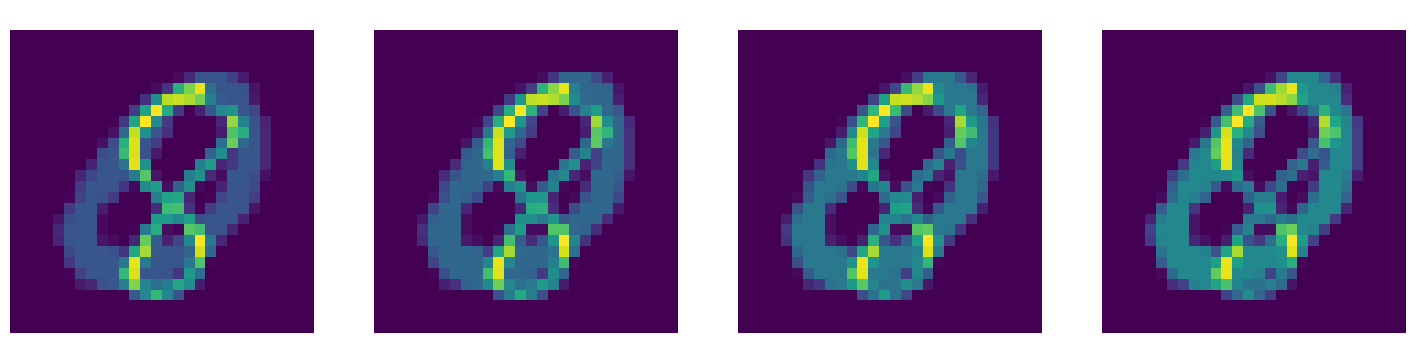

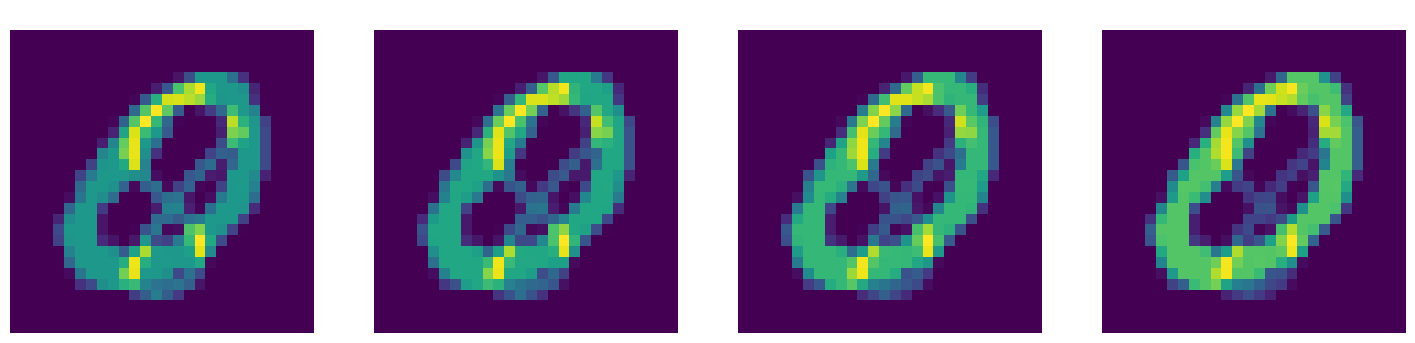

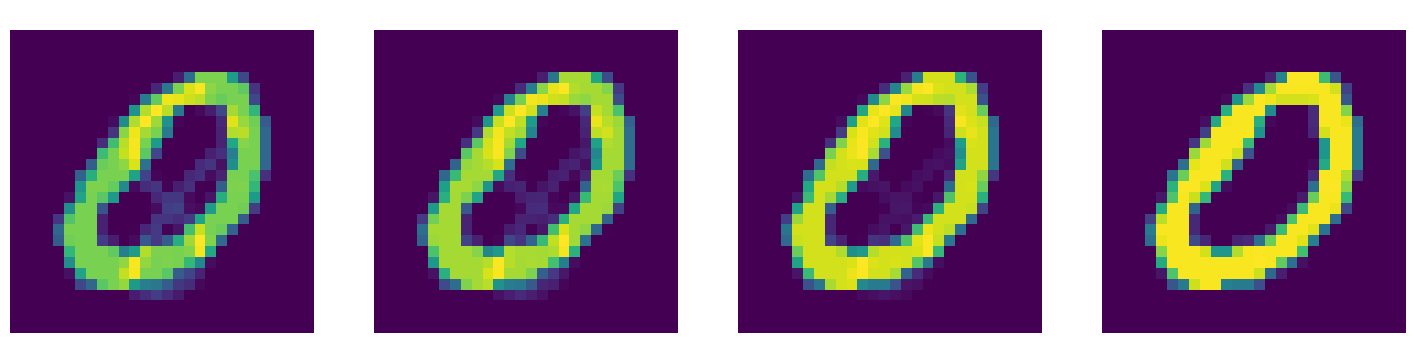

In [28]:
num_points = 16
sample = torch.Tensor(num_points, 28, 28).to(device)
for i in range(num_points):
    sample[i] = i / (N - 1) * x[end] + (1 - i / (N - 1) ) * x[start]
display_images_VAE(None, sample, num_points // 4, count=True)

# 6. Visualize the hidden vectors

In [29]:
import numpy as np
from sklearn.manifold import TSNE


In [39]:
hidden_vectors = values['mu'][9].numpy()
labels = values['label'][9].numpy().reshape(-1,1)
print(hidden_vectors.shape, labels.shape)

(10000, 20) (10000, 1)


In [42]:
embedded_vectors = TSNE(n_components=2).fit_transform(hidden_vectors[:5000,:])
print(embedded_vectors.shape)

(5000, 2)


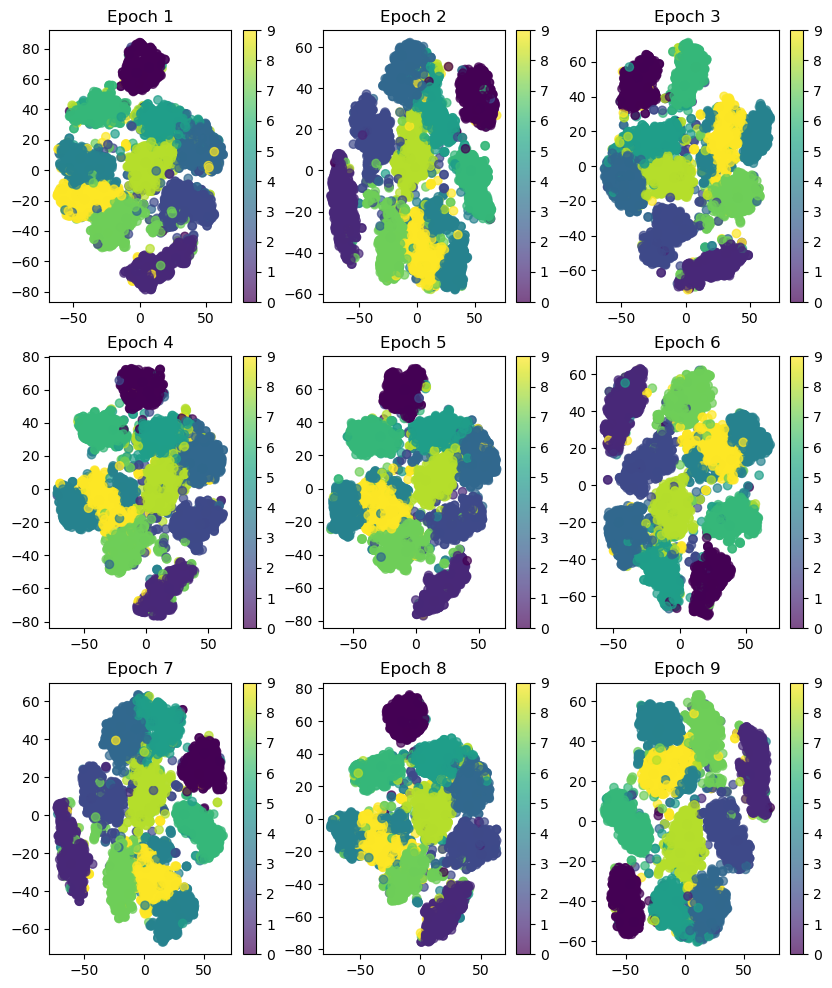

In [49]:
plt.figure(figsize=(10,12))
for i in range(1,10):
    hidden_vectors = values['mu'][i].numpy()
    labels = values['label'][i].numpy().reshape(-1,1)
    embedded_vectors = TSNE(n_components=2).fit_transform(hidden_vectors[:5000,:])
    plt.subplot(3,3,i)
    plt.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1], 
                c=labels[:5000,:],cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.title(f'Epoch {i}')